In [1]:
# CNN + LSTM + Multi-Head-Attention + CNN 的结构

In [2]:
# 准备数据
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt

In [3]:
np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

# np.random.seed(1027)
# torch.manual_seed(1027)
# torch.cuda.manual_seed(1027)
torch.backends.cudnn.deterministic = True

In [4]:
# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date'], axis=1)
dataset = dataset.fillna(0)

In [5]:
# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
TRAIN_VALIDATION_RATIO = 0.9
TRAIN_BATCH_SIZE = 40                                                        # 注意：BATCH_SIZE是要能够整除(total_seq_count-1)的
TEST_BATCH_SIZE = 1
SEQ_LENGTH = 25
Y_SEQ_LEN = 1                                                         # 要用2个y来表示预测的第一天和预测的第二天，对应 "future" 和 "future2",每个y都是1-D的，y的seq_len是2
Y_DIM = 1
X_DIM = dataset.shape[1]-Y_SEQ_LEN                                    # 表示输入的sequence里每个element有122维度，也是encoder的input_dim

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                   # 数据一共是 seq_count x seq_len x (x_in_dim+Y_SEQ_LEN) 

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))

# TEST_BATCH_COUNT  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
TEST_BATCH_SIZE  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
if TEST_BATCH_SIZE == 0:                                                                   # 如果 rolling_data 刚好被整除，那就专门留一整块给test，全部算一个batch
    TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
TEST_BATCH_COUNT = 1
TRAIN_BATCH_COUNT = int(((rolling_data.shape[0]-TEST_BATCH_SIZE*TEST_BATCH_COUNT)//TRAIN_BATCH_SIZE) * TRAIN_VALIDATION_RATIO)
VALID_BATCH_COUNT = int(((rolling_data.shape[0]-TEST_BATCH_SIZE*TEST_BATCH_COUNT)//TRAIN_BATCH_SIZE) - TRAIN_BATCH_COUNT)

print("TRAIN_BATCH_COUNT : {}".format(TRAIN_BATCH_COUNT))
print("VALID_BATCH_COUNT : {}".format(VALID_BATCH_COUNT))
print("TEST_BATCH_COUNT  : {}".format(TEST_BATCH_COUNT))

# train = rolling_data[:-test_seq_count].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 tain_batch_count x BATCH_SIZE x seq_len x in_dim 格式
# test  = rolling_data[-test_seq_count:].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 test_batch_count x BATCH_SIZE x seq_len x in_dim 格式

train = rolling_data[:TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE].reshape(TRAIN_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
valid = rolling_data[TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE:-TEST_BATCH_COUNT*TEST_BATCH_SIZE].reshape(VALID_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)     # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-TEST_BATCH_COUNT*TEST_BATCH_SIZE:].reshape(TEST_BATCH_COUNT, TEST_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                     # 把数据转成 test_batch_count x TEST_BATCH_SIZE x seq_len x in_dim 格式

TRAIN_BATCH_COUNT = train.shape[0]
TRAIN_BATCH_SIZE = train.shape[1]
VALID_BATCH_COUNT = valid.shape[0]
VALID_BATCH_SIZE = valid.shape[1]
TEST_BATCH_COUNT = test.shape[0]
TEST_BATCH_SIZE = test.shape[1]

train = torch.tensor(train)
valid = torch.tensor(valid)
test  = torch.tensor(test)


train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
valid_x, valid_y = valid[:,:,:,Y_SEQ_LEN:], valid[:,:,-1:,0:Y_SEQ_LEN]           # [valid_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]

train_y = train_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
valid_y = valid_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
test_y  =  test_y.permute(0, 1, 3, 2)                                    # conver from [test_batch_count, batch_size, seq_length, y_seq_len]  to  [test_batch_count, batch_size, y_seq_len, 1-dim]


train_x = train_x.to(device)
train_y = train_y.to(device)
valid_x = valid_x.to(device)
valid_y = valid_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("valid_x: {}".format(valid_x.shape))
print("valid_y: {}".format(valid_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train.shape[0]))
print("valid_batch_count: {}".format(valid.shape[0]))
print("test_batch_count:  {}".format(test.shape[0]))

rolling_data shape: (786, 25, 139)
seq count: 786
seq length: 25
TRAIN_BATCH_COUNT : 17
VALID_BATCH_COUNT : 2
TEST_BATCH_COUNT  : 1
train_x: torch.Size([17, 40, 25, 138])
train_y: torch.Size([17, 40, 1, 1])
valid_x: torch.Size([2, 40, 25, 138])
valid_y: torch.Size([2, 40, 1, 1])
test_x:  torch.Size([1, 26, 25, 138])
test_y:  torch.Size([1, 26, 1, 1])
train_batch_count: 17
valid_batch_count: 2
test_batch_count:  1


In [6]:
# 定义 LSTM 模型

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_dim_size, num_layers, output_size, attention_size=5, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_dim_size
        self.sequence_length = SEQ_LENGTH
        self.attention_size = attention_size
        self.num_layers = num_layers
        self.attention_size = attention_size    
        self.output_size = output_size
        
        self.conv1 = nn.Conv1d(input_size, 512, kernel_size=3, padding='same')        
        self.conv2 = nn.Conv1d(input_size, 512, kernel_size=5, padding='same')
        self.conv3 = nn.Conv1d(input_size, 512, kernel_size=7, padding='same')
        self.conv4 = nn.Conv1d(input_size, 512, kernel_size=9, padding='same')
        self.bn1 = nn.BatchNorm1d(256)  
        self.bn2 = nn.BatchNorm1d(self.hidden_size)
        
        self.conv01 = nn.Conv1d(input_size, 256, kernel_size=3, padding='same')        
        self.conv02 = nn.Conv1d(input_size, 256, kernel_size=5, padding='same')
        self.conv03 = nn.Conv1d(input_size, 256, kernel_size=7, padding='same')
        self.conv04 = nn.Conv1d(input_size, 256, kernel_size=9, padding='same')
          
            
        self.conv31 = nn.Conv1d(self.hidden_size, 512, kernel_size=3, padding='same')        
        self.conv32 = nn.Conv1d(512, 256, kernel_size=5, padding='same')
        self.conv33 = nn.Conv1d(256, 128, kernel_size=7, padding='same')
        self.conv34 = nn.Conv1d(128, 64, kernel_size=9, padding='same')
        self.linear35 = nn.Linear(64, self.output_size)    # 这个是给最后的多头注意力再乘 W0 的
        
                
        self.num_attention_head = 64                                                                  # 64
        self.attention_head_size = int(self.hidden_size/self.num_attention_head)                      # 每个头是32个维度
        self.all_head_size = self.num_attention_head * self.attention_head_size                       # 所有的头的维度合集
        
        self.dropout = nn.Dropout(dropout)
        
        self.layer_norm = nn.LayerNorm(self.hidden_size, elementwise_affine=False)
        
        self.lstm1 = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout)

        self.linear_1 = nn.Linear(input_size, self.hidden_size)          # 这个是将输入的维度转换成 hidden_dim 的
        self.linear_2 = nn.Linear(self.hidden_size, self.hidden_size)    # 这个是给最后的多头注意力再乘 W0 的
        self.linear_3 = nn.Linear(self.hidden_size, self.output_size)    # 这个是给最后的多头注意力再乘 W0 的
        
        self.relu = nn.LeakyReLU()                                       # 用 relu 来增强模型非线性
        self.tanh = nn.Tanh()
        
        # self.query = nn.Linear(self.hidden_size, self.hidden_size)     # 输入768， 输出多头的维度总数。这里还是768.
        # self.key = nn.Linear(self.hidden_size, self.hidden_size)       # 输入768， 输出多头的维度总数。这里还是768.
        # self.value = nn.Linear(self.hidden_size, self.hidden_size)     # 输入768， 输出多头的维度总数。这里还是768.
        
        self.query = nn.Linear(self.hidden_size, self.all_head_size)     # 输入768， 输出多头的维度总数。这里还是768.
        self.key = nn.Linear(self.hidden_size, self.all_head_size)       # 输入768， 输出多头的维度总数。这里还是768.
        self.value = nn.Linear(self.hidden_size, self.all_head_size)     # 输入768， 输出多头的维度总数。这里还是768.
        
  
        self.init_weights3()

    def init_weights1(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def init_weights2(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
                
    def init_weights3(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
    
    def init_weights4(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.normal_(param, mean=0, std=1)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.normal_(param, mean=0, std=1)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
    
    
    def conv_net(self, x):
        
        x = x.permute(0, 2, 1)
        
        x1 = self.relu(self.conv1(x))
        x1 = x1.permute(0, 2, 1)
        x1 = F.max_pool1d(x1, 2)
                
        x2 = self.relu(self.conv2(x))
        x2 = x2.permute(0, 2, 1)
        x2 = F.max_pool1d(x2, 2)

        x3 = self.relu(self.conv3(x))
        x3 = x3.permute(0, 2, 1)
        x3 = F.max_pool1d(x3, 2)
       
        x4 = self.relu(self.conv4(x))
        x4 = x4.permute(0, 2, 1)
        x4 = F.max_pool1d(x4, 2)
        
        
        x = torch.cat([x1, x2, x3, x4], 2)
               
        return x

    
    def conv_net2(self, x):
        
        x = x.permute(0, 2, 1)
        
        x1 = F.relu(self.conv01(x))
        x1 = x1.permute(0, 2, 1)
                
        x2 = F.relu(self.conv02(x))
        x2 = x2.permute(0, 2, 1)

        x3 = F.relu(self.conv03(x))
        x3 = x3.permute(0, 2, 1)
       
        x4 = F.relu(self.conv04(x))
        x4 = x4.permute(0, 2, 1)
        
        
        x = torch.cat([x1, x2, x3, x4], 2)
        
        return x

    def conv_net3(self, x):
        
        x = x.permute(0, 2, 1)
        
        x = F.relu(self.conv31(x))
        x = F.max_pool1d(x, 2)

        x = F.relu(self.conv32(x))
        x = F.max_pool1d(x, 2)
                
        x = F.relu(self.conv33(x))
        x = F.max_pool1d(x, 2)
        
        x = F.relu(self.conv34(x))
        x = F.max_pool1d(x, 2)
        
        
        x = x.permute(0, 2, 1)
        
        return x
    
    def attention_net(self, in_value, mask=None):
        # print(lstm_output.size())                                                   # [batch_size, seq_len, hidden_dim_size]
        # print(query.size())                                                         # [batch_size, seq_len, hidden_dim_size]
        # key   = lstm_output.transpose(1,2)
        # query = lstm_output
        # value = lstm_output
        batch_size = in_value.shape[0]
        seq_len = in_value.shape[1]
        hidden_dim = in_value.shape[2]
        
        # Q = self.query(in_value)
        # K = self.key(in_value)
        # V = self.value(in_value)
        # V = in_value
        
        # Q : [batch_size, seq_len, hidden_dim] ==> [batch_size, seq_len, num_head, head_size] ==> [batch_size, num_head, seq_len, head_size]
        Q = self.query(in_value).reshape(batch_size, seq_len, self.num_attention_head, self.attention_head_size).permute(0, 2, 1, 3)      # 先将 hidden_dim 切成 num_head * head_size ，再将 num_head 和 seq_len互换
        K = self.key(in_value).reshape(batch_size, seq_len, self.num_attention_head, self.attention_head_size).permute(0, 2, 1, 3)        # 先将 hidden_dim 切成 num_head * head_size ，再将 num_head 和 seq_len互换
        V = self.value(in_value).reshape(batch_size, seq_len, self.num_attention_head, self.attention_head_size).permute(0, 2, 1, 3)      # 先将 hidden_dim 切成 num_head * head_size ，再将 num_head 和 seq_len互换
        
        # d_k = Q.size(-1)                                                                            # d_k为query的维度。避免概率接近0
        
        # attention_scores = torch.matmul(query, lstm_output.transpose(1, 2)) / math.sqrt(d_k)     #打分机制  [batch_size, seq_len, hid_dim] * [batch_size, hid_dim, seq_len] ==> scores:[batch_size, seq_len, seq_len], 每个值就是两个输入x元素的相似性
        attention_scores = torch.matmul(Q, K.transpose(-1, -2))                                    # [batch_size, num_head, seq_len, head_size] * [batch_size, num_head, head_size, seq_len] ==> [batch_size, num_head, seq_len, seq_len]
        
        # attention_scores = attention_scores / math.sqrt(d_k)                                       # [batch_size, seq_len, seq_len]
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)                  # 多头机制下，hidden-dim被划分为 num_head个区域，所以现在要除的就是每个小区域的维度开方
        
        # alpha = F.softmax(attention_scores, dim = -1)                                            #对最后一个维度归一化得分  [batch_size, seq_len, seq_len] 保证相似性在一行上归一了。
        alpha = nn.Softmax(dim=-1)(attention_scores)                                               # 因为alpha是方阵，0维的seq_len就是真正的序列长度，1维的seq_len是对应每一个element和序列元素相关性。
        
        # alpha = self.dropout(alpha)

        attention = torch.matmul(alpha, V)                                            # [batch_size, num_head, seq_len, seq_len] * [batch_size, num_head, seq_len, head_size] = [batch_size, num_head, seq_len, head_size]
        
        attention = attention.permute(0, 2, 1, 3).contiguous()                       # [batch_size, num_head, seq_len, head_size] ==> [batch_size, seq_len, num_head, head_size]
        # new_attention_shape = attention.size()[:-2] + (self.all_head_size,)
        # attention = attention.view(*new_attention_shape)
        attention = attention.reshape(batch_size, seq_len, self.all_head_size)
        
        attention = self.linear_2(attention)
        
        return attention      
        
    
    def forward(self, x, hidden, cell):
        
        # x = self.conv_net(x)
        
        x = self.conv_net2(x)
        
        # x = self.linear_1(x)

        lstm1_out, (h1_n, c1_n) = self.lstm1(x, (hidden, cell))
        
        lstm1_out = self.dropout(lstm1_out)
        
        lstm1_out,  (h2_n, c2_n) = self.lstm2(lstm1_out, (h1_n, c1_n))
        
        attn_output = self.attention_net(lstm1_out)       #和LSTM的不同就在于这一句
        
        # attn_output = self.dropout(attn_output)
        
        attn_output = self.conv_net3(attn_output)

        predictions = self.linear35(attn_output)
        
        
        return predictions, h2_n, c2_n


In [7]:
# 训练 LSTM 模型 ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异

HIDDEN_SIZE = 1024
NUM_LAYERS = 2

def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

model = LSTMModel(input_size=X_DIM, hidden_dim_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1).double().to(device)
LR = 1e-5
# loss_func = nn.MSELoss(reduction="mean")
loss_func = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)

9 of 200 epoch   train_loss: 1.540324   valid_loss: 1.321136
19 of 200 epoch   train_loss: 1.332673   valid_loss: 1.273994
29 of 200 epoch   train_loss: 1.306886   valid_loss: 1.254622
39 of 200 epoch   train_loss: 1.288151   valid_loss: 1.206110
49 of 200 epoch   train_loss: 1.304836   valid_loss: 1.127975
59 of 200 epoch   train_loss: 0.637856   valid_loss: 0.925720
69 of 200 epoch   train_loss: 0.538990   valid_loss: 0.335559
79 of 200 epoch   train_loss: 0.316390   valid_loss: 0.398936
89 of 200 epoch   train_loss: 0.594407   valid_loss: 0.105267
99 of 200 epoch   train_loss: 0.447548   valid_loss: 0.137252
109 of 200 epoch   train_loss: 0.562774   valid_loss: 0.107506
119 of 200 epoch   train_loss: 0.472864   valid_loss: 0.103889
129 of 200 epoch   train_loss: 0.252656   valid_loss: 0.231417
139 of 200 epoch   train_loss: 0.419483   valid_loss: 0.155630
149 of 200 epoch   train_loss: 0.526294   valid_loss: 0.465647
159 of 200 epoch   train_loss: 0.337825   valid_loss: 0.119846
169

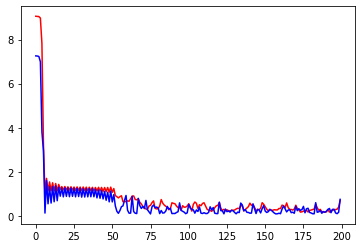

In [8]:
# 训练 LSTM 模型;  ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
model.train()
epoches = 200
train_epoch_loss = 0
train_epoch_loss_list = []
valid_smallest_loss = 1
valid_smallest_epoch = 0
valid_epoch_loss = 0
valid_epoch_loss_list = []

train_batch_count = train_x.shape[0]
valid_batch_count = valid_x.shape[0]

h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)


for epoch in range(epoches):
    batch_loss = []
    train_epoch_loss = 0
    train_pred_value_list = []
    train_real_value_list = []
    train_batch_list = list(range(0,train_batch_count))
    # random.shuffle(train_batch_list)
    for step in train_batch_list:
        train_pred, hn, cn = model(train_x[step], h0, c0)
        # h0, c0 = hn.detach(), cn.detach()
        loss = loss_func(train_pred[:,-1,-1], train_y[step][:,-1,-1])                # Compare the all sequences' last element in one batch
        train_pred_value_list.extend(list(train_pred[:,-1].cpu().detach().flatten().numpy() ))
        train_real_value_list.extend(list(train_y[step,:,-1,-1].cpu().detach().flatten().numpy() ))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        batch_loss.append(loss.cpu().data.numpy())
    # print(batch_loss)
    train_epoch_loss = np.mean(batch_loss)

    batch_loss = []
    valid_epoch_loss = 0
    valid_pred_value_list = []
    valid_real_value_list = []
    for step in range(valid_batch_count):
        valid_pred, hn, cn = model(valid_x[step], h0, c0)
        loss = loss_func(valid_pred[:,-1], valid_y[step][:,-1,-1])
        valid_pred_value_list.extend(list(valid_pred[:,-1].cpu().detach().flatten().numpy()))
        valid_real_value_list.extend(list(valid_y[step,:,-1,-1].cpu().detach().flatten().numpy()))
        batch_loss.append(loss.cpu().data.numpy())
    # print(batch_loss)
    valid_epoch_loss = np.mean(batch_loss)
    
    if ((epoch+1) %10) == 0:
        print("{} of {} epoch   train_loss: {:.6f}   valid_loss: {:.6f}".format(epoch, epoches, train_epoch_loss, valid_epoch_loss))

    valid_epoch_loss_list.append(valid_epoch_loss)
    train_epoch_loss_list.append(train_epoch_loss)

plt.plot(train_epoch_loss_list, 'r-')
plt.plot(valid_epoch_loss_list, 'b-')
plt.show()    

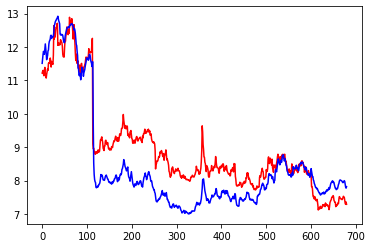

In [9]:
# 这是 train 的预测图形
plt.plot(train_real_value_list, 'r-')
plt.plot(train_pred_value_list, 'b-')
plt.show()
# print(train_real_value_list)

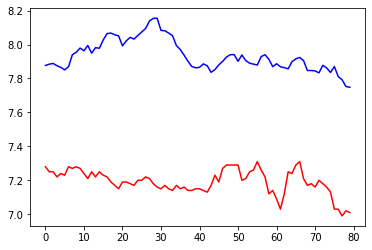

In [10]:
# 这是 vali的预测图形
plt.plot(valid_real_value_list, 'r-')
plt.plot(valid_pred_value_list, 'b-')
plt.show()

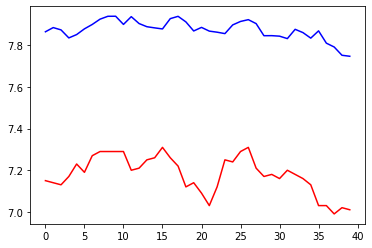

[7.15 7.14 7.13 7.17 7.23 7.19 7.27 7.29 7.29 7.29 7.29 7.2  7.21 7.25
 7.26 7.31 7.26 7.22 7.12 7.14 7.09 7.03 7.12 7.25 7.24 7.29 7.31 7.21
 7.17 7.18 7.16 7.2  7.18 7.16 7.13 7.03 7.03 6.99 7.02 7.01]
[7.86587789 7.88601396 7.87488736 7.83633175 7.8523973  7.87991074
 7.9010623  7.92652405 7.94029165 7.94054105 7.90125909 7.93855908
 7.90542838 7.89023613 7.88461328 7.87947404 7.92906866 7.94011897
 7.91335351 7.86974345 7.88689279 7.86901929 7.86382685 7.85700619
 7.89887297 7.91551463 7.92413376 7.90510493 7.84694265 7.84716972
 7.84477144 7.83300988 7.87765678 7.86185505 7.83527727 7.87019129
 7.8110947  7.79267941 7.7528725  7.74810676]
tensor([7.1500, 7.1400, 7.1300, 7.1700, 7.2300, 7.1900, 7.2700, 7.2900, 7.2900,
        7.2900, 7.2900, 7.2000, 7.2100, 7.2500, 7.2600, 7.3100, 7.2600, 7.2200,
        7.1200, 7.1400, 7.0900, 7.0300, 7.1200, 7.2500, 7.2400, 7.2900, 7.3100,
        7.2100, 7.1700, 7.1800, 7.1600, 7.2000, 7.1800, 7.1600, 7.1300, 7.0300,
        7.0300, 6.9900, 7.02

In [11]:
# 这是 valid 最后一段的数据。误差累积到这里已经很大了。
plt.plot(valid_y[-1,:,-1,-1].cpu().detach().flatten().numpy(), 'r-')
plt.plot(valid_pred[:,-1].cpu().detach().flatten().numpy(), 'b-')
plt.show()
print(valid_y[-1,:,-1,-1].cpu().detach().flatten().numpy())
print(valid_pred[:,-1].cpu().detach().flatten().numpy())
print(valid_y[-1,:,-1,-1])

Test Loss : 1.840117
Prediction: 7.96
Actual:     0.00


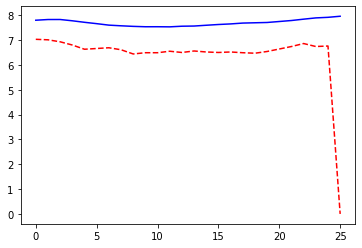

tensor([7.0300, 7.0100, 6.9300, 6.8000, 6.6300, 6.6600, 6.6900, 6.6100, 6.4400,
        6.4900, 6.4900, 6.5500, 6.5000, 6.5600, 6.5200, 6.5000, 6.5200, 6.4900,
        6.4700, 6.5400, 6.6400, 6.7400, 6.8600, 6.7400, 6.7600, 0.0000],
       device='cuda:0', dtype=torch.float64)
tensor([[7.7984],
        [7.8266],
        [7.8276],
        [7.7758],
        [7.7151],
        [7.6603],
        [7.6009],
        [7.5741],
        [7.5511],
        [7.5358],
        [7.5365],
        [7.5319],
        [7.5572],
        [7.5644],
        [7.5960],
        [7.6263],
        [7.6497],
        [7.6838],
        [7.6958],
        [7.7076],
        [7.7471],
        [7.7870],
        [7.8412],
        [7.8922],
        [7.9153],
        [7.9588]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)


In [12]:
# 用模型预测数据
# 考虑到时序因素，这里的时候误差很大。
model.eval()
test_loss = 0

h0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).double().to(device)

for step in range(test_x.shape[0]):
    pred, hn, cn = model(test_x[step], h0, c0)
    
    loss = loss_func(pred[:,-1], test_y[step][:,-1,-1])               # Compare the all sequences' last element in one batch
    
    if test_x.shape[0] > 1:
        actual_line.append(test_y[step][-1,-1].item())
        pred_line.append(pred[-1,-1].item())
    elif test_x.shape[0] == 1:
        actual_line = test_y[step].cpu().detach().flatten().numpy()        # Only plot the last sequence of test batch
        pred_line   = pred[:,-1].cpu().detach().flatten().numpy()                # Only plot the last sequence of test batch
        
print("Test Loss : {:.6f}".format(loss.data))
print("Prediction: {:.2f}".format(float(pred[-1,-1].data)))
print("Actual:     {:.2f}".format(float(test_y[step][-1,-1].data)))


plt.plot(test_y[step,:,-1,-1].cpu().detach().flatten().numpy(), 'r--')
plt.plot(pred[:,-1].cpu().detach().flatten().numpy(), 'b-')
plt.show()
print(test_y[step,:,-1,-1])
print(pred[:,-1])

In [13]:
# 把rolling_data再分割为 train / test 就再预测
# 既然 预测值 和时序相关性很高，可以考虑太早的零星数据对于test影响不大，可以删掉
print(rolling_data.shape)
print(TRAIN_BATCH_SIZE)
print(((rolling_data.shape[0]-1)//TRAIN_BATCH_SIZE)*TRAIN_BATCH_SIZE)
rolling_data = rolling_data[-((rolling_data.shape[0]-1)//TRAIN_BATCH_SIZE)*TRAIN_BATCH_SIZE-1:,]
print(rolling_data.shape)

train = rolling_data[:-1].reshape(-1, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-1:].reshape(1, 1, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                     # 把数据转成 test_batch_count x TEST_BATCH_SIZE x seq_len x in_dim 格式

train = torch.tensor(train).to(device)
test  = torch.tensor(test).to(device)

train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
print(test_y)

(786, 25, 139)
40
760
(761, 25, 139)
torch.Size([19, 40, 25, 138]) torch.Size([19, 40, 1, 1])
torch.Size([1, 1, 25, 138]) torch.Size([1, 1, 1, 1])
tensor([[[[0.]]]], device='cuda:0', dtype=torch.float64)


9 of 200 epoch   train_loss: 1.582888
19 of 200 epoch   train_loss: 1.576295
29 of 200 epoch   train_loss: 1.533347
39 of 200 epoch   train_loss: 1.499707
49 of 200 epoch   train_loss: 1.478515
59 of 200 epoch   train_loss: 1.496453
69 of 200 epoch   train_loss: 1.587220
79 of 200 epoch   train_loss: 0.742684
89 of 200 epoch   train_loss: 0.466476
99 of 200 epoch   train_loss: 0.466827
109 of 200 epoch   train_loss: 0.327089
119 of 200 epoch   train_loss: 0.264600
129 of 200 epoch   train_loss: 0.216088
139 of 200 epoch   train_loss: 0.333447
149 of 200 epoch   train_loss: 0.215029
159 of 200 epoch   train_loss: 0.407845
169 of 200 epoch   train_loss: 0.305141
179 of 200 epoch   train_loss: 0.221789
189 of 200 epoch   train_loss: 0.296060
199 of 200 epoch   train_loss: 0.196451


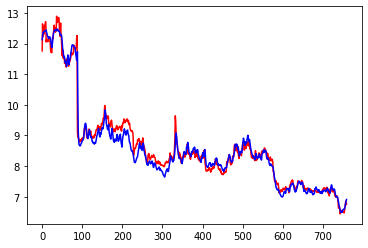

In [14]:
# 再重新生成模型再 train 模型
model = LSTMModel(input_size=X_DIM, hidden_dim_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1).double().to(device)
LR = 1e-5
# loss_func = nn.MSELoss(reduction="mean")
loss_func = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)
model.train()

h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)


for epoch in range(epoches):
    batch_loss = []
    train_epoch_loss = 0
    train_pred_value_list = []
    train_real_value_list = []
    train_batch_list = list(range(0,train_batch_count))
    # random.shuffle(train_batch_list)
    for step in range(0, train_x.shape[0]):
        train_pred, hn, cn = model(train_x[step], h0, c0)
        # h0, c0 = hn.detach(), cn.detach()
        loss = loss_func(train_pred[:,-1,-1], train_y[step][:,-1,-1])                # Compare the all sequences' last element in one batch
        train_pred_value_list.extend(list(train_pred[:,-1,-1].cpu().detach().flatten().numpy() ))
        train_real_value_list.extend(list(train_y[step,:,-1,-1].cpu().detach().flatten().numpy() ))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        batch_loss.append(loss.cpu().data.numpy())
    if ((epoch+1) %10) == 0:
        print("{} of {} epoch   train_loss: {:.6f}".format(epoch, epoches, np.mean(batch_loss)))
    train_epoch_loss = np.mean(batch_loss)
    
plt.plot(train_real_value_list, 'r-')
plt.plot(train_pred_value_list, 'b-')
plt.show()    

In [15]:
print(train_pred.shape)
print(train_y.shape)

print(train_y[-1,-1])
print(train_pred[-1,-1])

torch.Size([40, 1, 1])
torch.Size([19, 40, 1, 1])
tensor([[6.7600]], device='cuda:0', dtype=torch.float64)
tensor([6.9112], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)


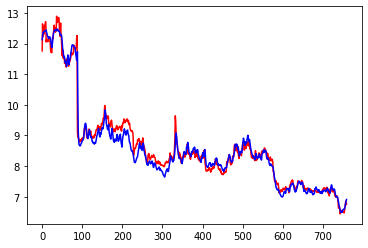

In [16]:
plt.plot(train_real_value_list, 'r-')
plt.plot(train_pred_value_list, 'b-')
plt.show()

In [17]:
# print(train_x.shape)
# print(test_x.shape)
print(train_real_value_list[-1])
print(train_pred_value_list[-1])

6.76
6.911240268402345


In [18]:
model.eval()

h0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).double().to(device)

pred, hn, cn = model(test_x[-1], h0, c0)

print(test_y.shape)
print(pred.shape)
print(test_y)
print(pred[:,-1,:])

torch.Size([1, 1, 1, 1])
torch.Size([1, 1, 1])
tensor([[[[0.]]]], device='cuda:0', dtype=torch.float64)
tensor([[6.9946]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SliceBackward0>)
